# BigContest Clustering

# 1. Setting Environment

## 1.1 Load libraries

In [4]:
library(data.table) # Data load
library(dplyr) # Preprocessing
library(tidyr) # preprocessing
library(ggplot2) # Visualization

## 1.2 Load data

In [5]:
activity <- fread("data/train_activity_new.csv", stringsAsFactors = F)
guild    <- fread("data/train_guild_new.csv", stringsAsFactors = F)
label    <- fread("data/train_label.csv", stringsAsFactors = F) %>%
  mutate(label = factor(label, levels = c("retained", "2month", "month", "week")))
payment  <- fread("data/train_payment_new.csv", stringsAsFactors = F)
trade    <- fread("data/train_trade_new.csv", stringsAsFactors = F)

Read 440323 rows and 39 (of 39) columns from 0.305 GB file in 00:00:14
Read 800000 rows and 4 (of 4) columns from 0.071 GB file in 00:00:03
Read 10414351 rows and 8 (of 8) columns from 1.743 GB file in 00:01:24


## 1.3 ETC Setting

In [25]:
theme_set(theme_minimal())
options(repr.plot.width = 10, repr.plot.height = 7)

# 2. Preprocessing

## 2.1 Transform trade

In [6]:
trade_new <- trade %>%
  gather(key = "role", value = "acc_id", source_acc_id, target_acc_id) %>%
  mutate(role = ifelse(role == "source_acc_id", "sell", "buy"),
         item_amount_new = (item_amount - min(item_amount))/(max(item_amount) - min(item_amount)))

In [7]:
trade_num <- trade_new %>% group_by(acc_id, role, item_type) %>%
  summarize(n_obs = n()) %>% ungroup() %>%
  mutate(type = paste0(role, "_", item_type)) %>%
  select(-role, -item_type) %>%
  spread(key = type, value = n_obs)
trade_num[is.na(trade_num)] <- 0
head(trade_num)

acc_id,buy_accessory,buy_costume,buy_gem,buy_grocery,buy_money,buy_weapon,sell_accessory,sell_costume,sell_gem,sell_grocery,sell_money,sell_weapon
0000264b01392acfde44f9d8494f112a701dc5d3e5fda6ad090cb205727637e0,0,0,0,12,0,0,0,0,0,12,12,0
0000548b3eecb5e8c6736f9408ddd58f49d0a553b6f1f835f198957ee63e49e4,0,0,0,0,0,0,0,0,0,2,2,0
00006916672106f94f68d18e4a0532b53a40f4549d3a62f0cbf677dd25803668,0,0,0,3,0,0,0,0,0,3,3,0
0000d57170ee9d25dfa6cc8c7fbe88d2ffb561637020a4dec2791f1ee9a56b88,0,0,0,2,0,0,0,0,0,2,2,0
0001f130e89288ff0df167b998f6eb7085687f411fcb72440d8a55fb2c0eabc8,0,0,0,0,0,0,0,0,0,0,2,0
00027152625b3c992d2e423b2d811d34c26a23eb3705d84dcde39cfb1b3bffd8,0,0,0,0,0,0,0,0,0,4,4,0


## 2.2 Transform payment

In [8]:
payment_sum <- payment %>% 
  mutate(payment_amount_new = (payment_amount - min(payment_amount))/(max(payment_amount) - min(payment_amount))) %>%
  group_by(acc_id) %>% summarize(sum_payment = sum(payment_amount))
head(payment_sum)

acc_id,sum_payment
0000264b01392acfde44f9d8494f112a701dc5d3e5fda6ad090cb205727637e0,-1.199188
0001f130e89288ff0df167b998f6eb7085687f411fcb72440d8a55fb2c0eabc8,-1.199188
00028f0ad71c07f48aef465fd0c98ba6e3f0f3de3d2f7d14c975f794dfb31e2b,-1.199188
00036e5b6a197c196fa10fc0ad4e2853b22294dff64d2735a2795ab3858d5b7a,-1.199188
00037fe8e712041a476b8b1b827583cbc34895844057f03da985c953f567e0f2,-1.199188
0003b127aa1c0c34490db8817574482464aad9f99cffde4d3e51790dff2cb6ca,-1.199188


In [9]:
payment_wk <- payment %>%
  select(-payment_id) %>%
  spread(key = "payment_week", value = "payment_amount")
names(payment_wk)[2:9] <- paste0("payment_wk", 1:8)
head(payment_wk)

acc_id,payment_wk1,payment_wk2,payment_wk3,payment_wk4,payment_wk5,payment_wk6,payment_wk7,payment_wk8
0000264b01392acfde44f9d8494f112a701dc5d3e5fda6ad090cb205727637e0,-0.1498985,-0.1498985,-0.1498985,-0.1498985,-0.1498985,-0.1498985,-0.1498985,-0.1498985
0001f130e89288ff0df167b998f6eb7085687f411fcb72440d8a55fb2c0eabc8,-0.1498985,-0.1498985,-0.1498985,-0.1498985,-0.1498985,-0.1498985,-0.1498985,-0.1498985
00028f0ad71c07f48aef465fd0c98ba6e3f0f3de3d2f7d14c975f794dfb31e2b,-0.1498985,-0.1498985,-0.1498985,-0.1498985,-0.1498985,-0.1498985,-0.1498985,-0.1498985
00036e5b6a197c196fa10fc0ad4e2853b22294dff64d2735a2795ab3858d5b7a,-0.1498985,-0.1498985,-0.1498985,-0.1498985,-0.1498985,-0.1498985,-0.1498985,-0.1498985
00037fe8e712041a476b8b1b827583cbc34895844057f03da985c953f567e0f2,-0.1498985,-0.1498985,-0.1498985,-0.1498985,-0.1498985,-0.1498985,-0.1498985,-0.1498985
0003b127aa1c0c34490db8817574482464aad9f99cffde4d3e51790dff2cb6ca,-0.1498985,-0.1498985,-0.1498985,-0.1498985,-0.1498985,-0.1498985,-0.1498985,-0.1498985


## 2.3 Transform guild

In [10]:
guild_num <- label %>% 
  left_join(guild %>% group_by(acc_id) %>% summarize(guild_num = n()),
            by = "acc_id") %>%
  mutate(guild_num = ifelse(is.na(guild_num), 0, 1)) %>%
  select(-label)
head(guild_num)

acc_id,guild_num
b8fbf3f6a70e3f36843bffc70c18ff51a0d755a87616eca21b17b94d2ee2a734,0
ed500c4957956b3e99dc3985666850b582f812405eefb6ee731c3cf90f339b72,0
acc6afa23a6bf15e18151e4794c7789225ef9d682f473c243fd6d6b4b456e1ae,0
34095a3c9a2937ced3ea3fd75e22ce177dc5879d2a53f7d88842c604510a7ae5,0
26f3db6e8817a93c4ceda9a16f0832945e43d950b95882f0e5a54ab7ed01bebe,0
aaf2fb67be2d51bf75b973df5587dda57aa147c123c2a4307827f3b023ff0f96,0


## 2.4 Transform activity

In [11]:
time <- activity %>% 
  mutate(play_time_new = (play_time - min(play_time))/(max(play_time) - min(play_time))) %>%
  group_by(acc_id) %>%
  summarize(wk_num = n(),
            acc_num = sum(cnt_dt),
            acc_mean = mean(cnt_dt),
            time_sum = sum(play_time_new),
            time_wk_mean = mean(play_time_new)) %>%
  mutate(time_acc_mean = time_sum/acc_num) %>%
  select(acc_id, wk_num, acc_num, time_sum)
head(time)

acc_id,wk_num,acc_num,time_sum
0000264b01392acfde44f9d8494f112a701dc5d3e5fda6ad090cb205727637e0,2,12,1.434052579
0001f130e89288ff0df167b998f6eb7085687f411fcb72440d8a55fb2c0eabc8,8,25,0.001299603
00028f0ad71c07f48aef465fd0c98ba6e3f0f3de3d2f7d14c975f794dfb31e2b,5,12,0.003850860
00036e5b6a197c196fa10fc0ad4e2853b22294dff64d2735a2795ab3858d5b7a,6,31,0.158948413
00037fe8e712041a476b8b1b827583cbc34895844057f03da985c953f567e0f2,2,3,0.002157738
0003b127aa1c0c34490db8817574482464aad9f99cffde4d3e51790dff2cb6ca,8,39,0.234343585


In [39]:
exp <- activity %>%
  mutate(npc_exp_new = (npc_exp - min(npc_exp))/(max(npc_exp) - min(npc_exp)),
         npc_hongmun_new = (npc_hongmun - min(npc_hongmun))/(max(npc_hongmun) - min(npc_hongmun)),
         quest_exp_new = (quest_exp - min(quest_exp))/(max(quest_exp) - min(quest_exp)),
         quest_hongmun_new = (quest_hongmun - min(quest_hongmun))/(max(quest_hongmun) - min(quest_hongmun)),
         item_hongmun_new = (item_hongmun - min(item_hongmun))/(max(item_hongmun) - min(item_hongmun))) %>%
  group_by(acc_id) %>%
  summarize(acc_num = sum(cnt_dt),
            npc_exp_wk_mean = mean(npc_exp_new),
            npc_exp_sum = sum(npc_exp_new),
            npc_hongmun_wk_mean = mean(npc_hongmun_new),
            npc_hongmun_sum = sum(npc_hongmun_new),
            quest_exp_wk_mean = mean(quest_exp_new),
            quest_exp_sum = sum(quest_exp_new),
            quest_hongmun_wk_mean = mean(quest_hongmun_new),
            quest_hongmun_sum = sum(quest_hongmun_new),
            item_hongmun_wk_mean = mean(item_hongmun_new),
            item_hongmun_sum = sum(item_hongmun_new)) %>%
  mutate(npc_exp_acc_mean = npc_exp_sum / acc_num,
         npc_hongmun_acc_mean = npc_hongmun_sum / acc_num,
         quest_exp_acc_mean = quest_exp_sum / acc_num,
         quest_hongmun_acc_mean = quest_hongmun_sum / acc_num,
         item_hongmun_acc_mean = item_hongmun_sum / acc_num) %>%
  select(-acc_num) %>%
  select(acc_id, npc_exp_sum, quest_exp_sum, npc_hongmun_sum, quest_hongmun_sum, item_hongmun_sum)
head(exp)

acc_id,npc_exp_sum,quest_exp_sum,npc_hongmun_sum,quest_hongmun_sum,item_hongmun_sum
0000264b01392acfde44f9d8494f112a701dc5d3e5fda6ad090cb205727637e0,0.3809793534,1.3083729123,0.0007753815,0.225648815,0.0000000000
0001f130e89288ff0df167b998f6eb7085687f411fcb72440d8a55fb2c0eabc8,0.0000000000,0.0000000000,0.0000000000,0.000000000,0.0000000000
00028f0ad71c07f48aef465fd0c98ba6e3f0f3de3d2f7d14c975f794dfb31e2b,0.0000259147,0.0004109844,0.0000000000,0.000000000,0.0000000000
00036e5b6a197c196fa10fc0ad4e2853b22294dff64d2735a2795ab3858d5b7a,0.0090312716,0.1235712206,0.0002182794,0.041978847,0.0002675048
00037fe8e712041a476b8b1b827583cbc34895844057f03da985c953f567e0f2,0.0000259147,0.0004109844,0.0000000000,0.000000000,0.0000000000
0003b127aa1c0c34490db8817574482464aad9f99cffde4d3e51790dff2cb6ca,0.0000000000,0.0000000000,0.0019382450,0.005506965,0.0027419247


In [13]:
dungeon_temp <- apply(activity[,c(17:30)], 2, function(x) { (x - min(x))/(max(x) - min(x)) }) %>% 
  as.data.frame() %>% cbind(activity[,c(2,3,4)]) %>% select(acc_id, wk, cnt_dt, everything())

dungeon <- dungeon_temp %>%
  mutate(enter_inzone = cnt_enter_inzone_solo + cnt_enter_inzone_normal,
         enter_skilled = cnt_enter_inzone_skilled,
         enter_raid = cnt_enter_raid + cnt_enter_raid_light,
         enter_bam = cnt_enter_bam,
         clear_inzone = cnt_clear_inzone_solo + cnt_clear_inzone_normal,
         clear_skilled = cnt_clear_inzone_skilled,
         clear_raid = cnt_clear_raid + cnt_clear_raid_light,
         clear_bam = cnt_clear_bam) %>%
  group_by(acc_id) %>%
  summarize(acc_num = sum(cnt_dt),
            enter_inzone_sum = sum(enter_inzone),
            enter_inzone_wk_mean = mean(enter_inzone),
            enter_skilled_sum = sum(enter_skilled),
            enter_skilled_wk_mean = mean(enter_skilled),
            enter_raid_sum = sum(enter_raid),
            enter_raid_wk_mean = mean(enter_raid),
            enter_bam_sum = sum(enter_bam),
            enter_bam_wk_mean = mean(enter_bam),
            clear_inzone_sum = sum(clear_inzone),
            clear_inzone_wk_mean = mean(clear_inzone),
            clear_skilled_sum = sum(clear_skilled),
            clear_skilled_wk_mean = mean(clear_skilled),
            clear_raid_sum = sum(clear_raid),
            clear_raid_wk_mean = mean(clear_raid),
            clear_bam_sum = sum(clear_bam),
            clear_bam_wk_mean = mean(clear_bam)) %>%
  mutate(enter_inzone_acc_mean = enter_inzone_sum / acc_num,
         enter_skilled_acc_mean = enter_skilled_sum / acc_num,
         enter_raid_acc_mean = enter_raid_sum / acc_num,
         enter_bam_acc_mean = enter_bam_sum / acc_num,
         clear_inzone_acc_mean = clear_inzone_sum / acc_num,
         clear_skilled_acc_mean = clear_skilled_sum / acc_num,
         clear_raid_acc_mean = clear_raid_sum / acc_num,
         clear_bam_acc_mean = clear_bam_sum / acc_num) %>%
  select(-acc_num) %>%
select(acc_id, enter_inzone_sum, enter_skilled_sum, 
       enter_raid_sum, clear_inzone_sum,
       clear_raid_sum, clear_bam_sum)
head(dungeon)

acc_id,enter_inzone_sum,enter_skilled_sum,enter_raid_sum,clear_inzone_sum,clear_raid_sum,clear_bam_sum
0000264b01392acfde44f9d8494f112a701dc5d3e5fda6ad090cb205727637e0,0.03225806,0,0,0.03898635,0,0
0001f130e89288ff0df167b998f6eb7085687f411fcb72440d8a55fb2c0eabc8,0.00000000,0,0,0.00000000,0,0
00028f0ad71c07f48aef465fd0c98ba6e3f0f3de3d2f7d14c975f794dfb31e2b,0.00000000,0,0,0.00000000,0,0
00036e5b6a197c196fa10fc0ad4e2853b22294dff64d2735a2795ab3858d5b7a,0.17877183,0,0,0.17894392,0,0
00037fe8e712041a476b8b1b827583cbc34895844057f03da985c953f567e0f2,0.00000000,0,0,0.00000000,0,0
0003b127aa1c0c34490db8817574482464aad9f99cffde4d3e51790dff2cb6ca,0.28982361,0,0,0.29173639,0,0


# 3. Data integration

In [40]:
game <- label %>% 
  left_join(trade_num, by = "acc_id") %>% 
  left_join(payment_sum, by = "acc_id") %>% 
  left_join(payment_wk, by = "acc_id") %>% 
  left_join(guild_num, by = "acc_id") %>% 
  left_join(time, by = "acc_id") %>% 
  left_join(exp, by = "acc_id") %>% 
  left_join(dungeon, by = "acc_id")
game[is.na(game)] <- 0

game_cluster <- apply(game[,3:38], 2, function(x) {scale(x)}) %>% data.frame()

# 4. Clustering

In [80]:
set.seed(8674)
k <- 4
kmeans_result <- kmeans(game_cluster, centers = k)

In [81]:
center_result <- kmeans_result$centers %>% data.frame()
center_result$cluster <- 1:k

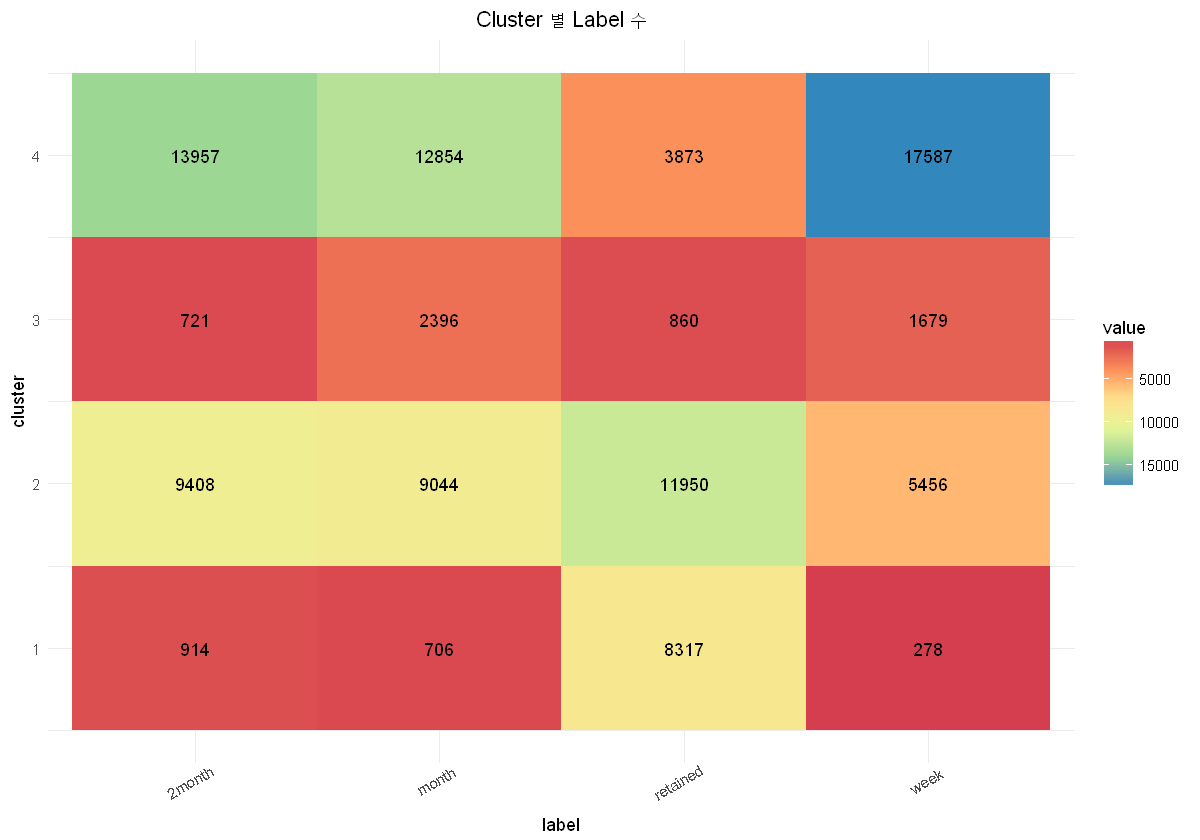

In [82]:
kmeans_df <- game %>% mutate(cluster = kmeans_result$cluster)
cluster_label <- kmeans_df %>% group_by(cluster, label) %>% summarize(n_obs = n()) %>%
  spread(key = "label", value = "n_obs")
cluster_label %>%
  gather(key = "label", value = "num", -cluster) %>%
  ggplot(aes(label, cluster, fill = num)) +
  geom_tile() + geom_text(aes(label = num)) +
  scale_fill_distiller(name = "value", palette = "Spectral", tran = "reverse") +
  labs(title = "Cluster 별 Label 수") +
  theme(axis.text.x = element_text(angle = 30, hjust = 0.7), plot.title = element_text(hjust = 0.5))

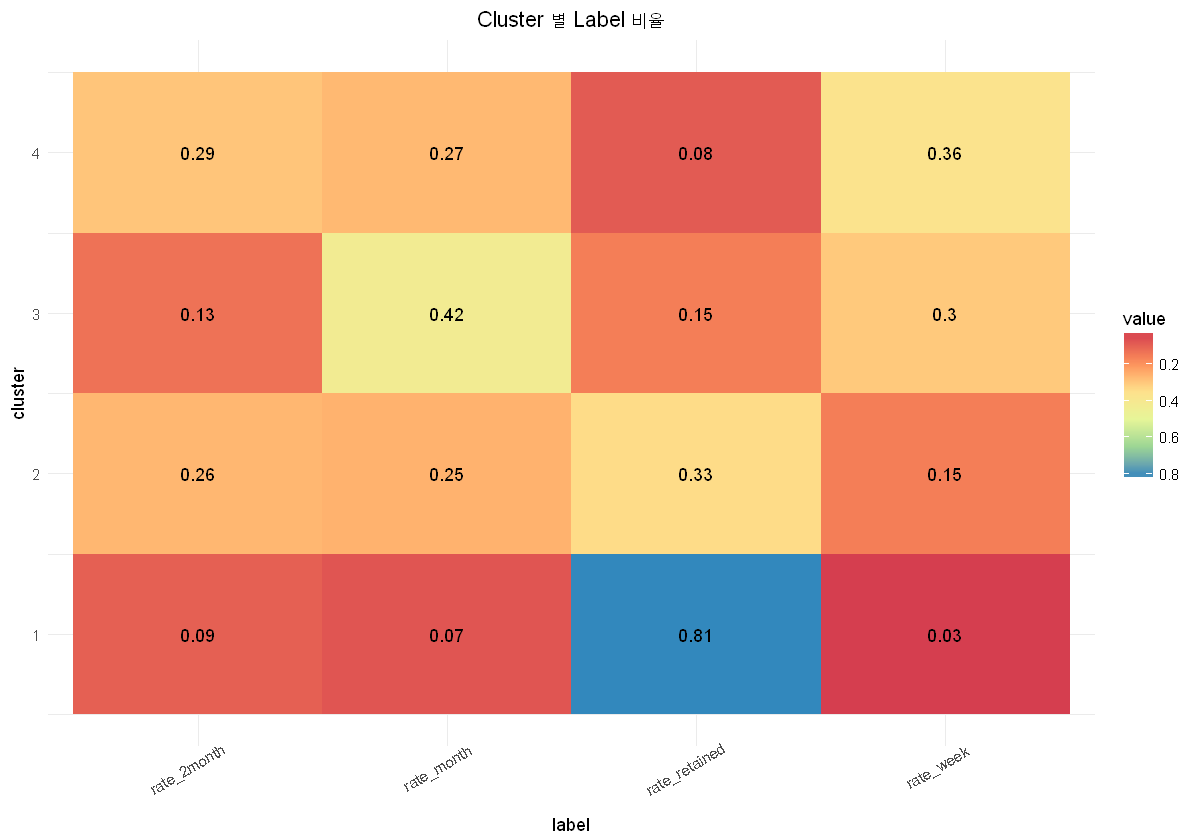

In [83]:
apply(cluster_label[2:5], 2, function(x) {x/rowSums(cluster_label[,-1])}) %>% 
  data.frame() %>% mutate(cluster = 1:k) %>%
  rename(rate_2month = X2month, 
         rate_month = month,
         rate_retained = retained,
         rate_week = week) %>%
  gather(key = "label", value = "num", -cluster) %>%
  ggplot(aes(label, cluster, fill = num)) +
  geom_tile() + geom_text(aes(label = round(num, 2))) +
  scale_fill_distiller(name = "value", palette = "Spectral", tran = "reverse") +
  labs(title = "Cluster 별 Label 비율") + 
  theme(axis.text.x = element_text(angle = 30, hjust = 0.7), plot.title = element_text(hjust = 0.5))

* Cluster 1 : retained 유저
* Cluster 4 : churn 유저
* Cluster 3 : month & week 유저
* Cluster 2 : 미묘...  
* Cluster 수를 바꿔서 해봐야 할듯


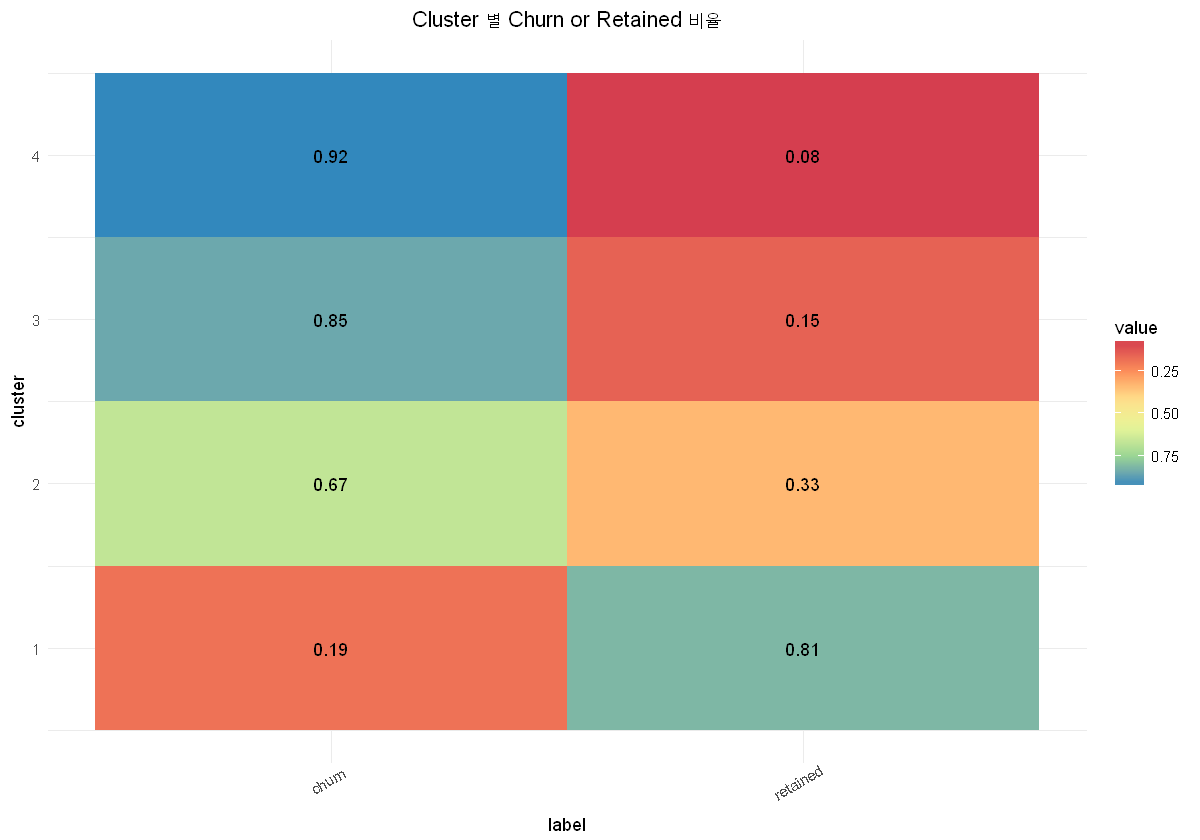

In [84]:
cluster_label$churn <- cluster_label[,c(3,4,5)] %>% rowSums() 
cluster_label_reduced <- cluster_label %>% select(cluster, retained, churn)
apply(cluster_label_reduced[,-1], 2, function(x) {x/rowSums(cluster_label_reduced[,-1])}) %>% 
  data.frame() %>% mutate(cluster = 1:k) %>%
  gather(key = "label", value = "rate", -cluster) %>%
  ggplot(aes(label, cluster, fill = rate)) +
  geom_tile() + geom_text(aes(label = round(rate, 2))) +
  scale_fill_distiller(name = "value", palette = "Spectral", tran = "reverse") +
  labs(title = "Cluster 별 Churn or Retained 비율") + 
  theme(axis.text.x = element_text(angle = 30, hjust = 0.7), plot.title = element_text(hjust = 0.5))

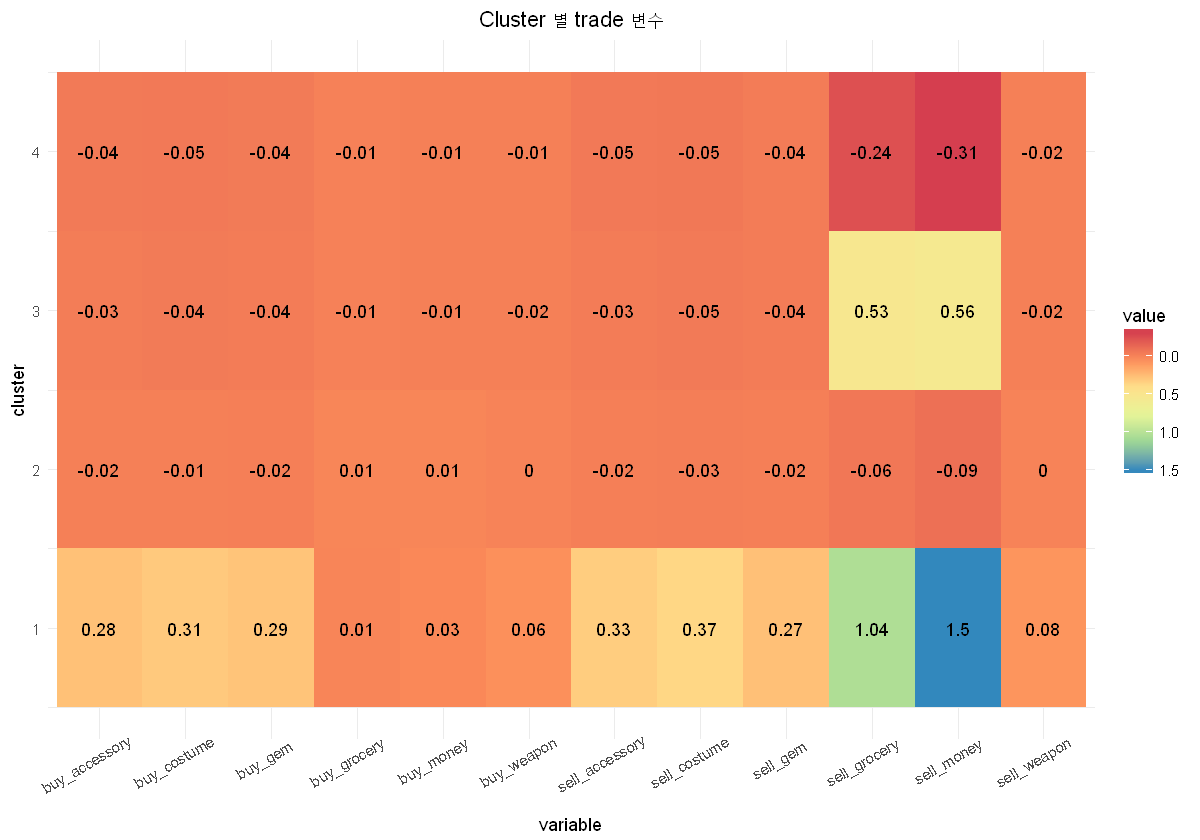

In [85]:
center_result[,c(1:12,37)] %>% 
  gather(key = "variable", value = "value", -cluster) %>%
  ggplot(aes(variable, cluster, fill = value)) + 
  geom_tile() + geom_text(aes(label = round(value, 2))) +
  scale_fill_distiller(name = "value", palette = "Spectral", tran = "reverse") +
  labs(title = "Cluster 별 trade 변수") +
  theme(axis.text.x = element_text(angle = 30, hjust = 0.7), plot.title = element_text(hjust = 0.5))

* Cluster 1 : buy_accessory / buy_costume / buy_gem가 높음
* Cluster 1 : sell_grocery / sell_money가 매우 높음
* Cluster 1 : sell 변수가 전반적으로 높음
* Cluster 3 : sell_grocery / sell_money가 높음
* Cluster 4 : sell_grocery / sell_money가 매우 낮음

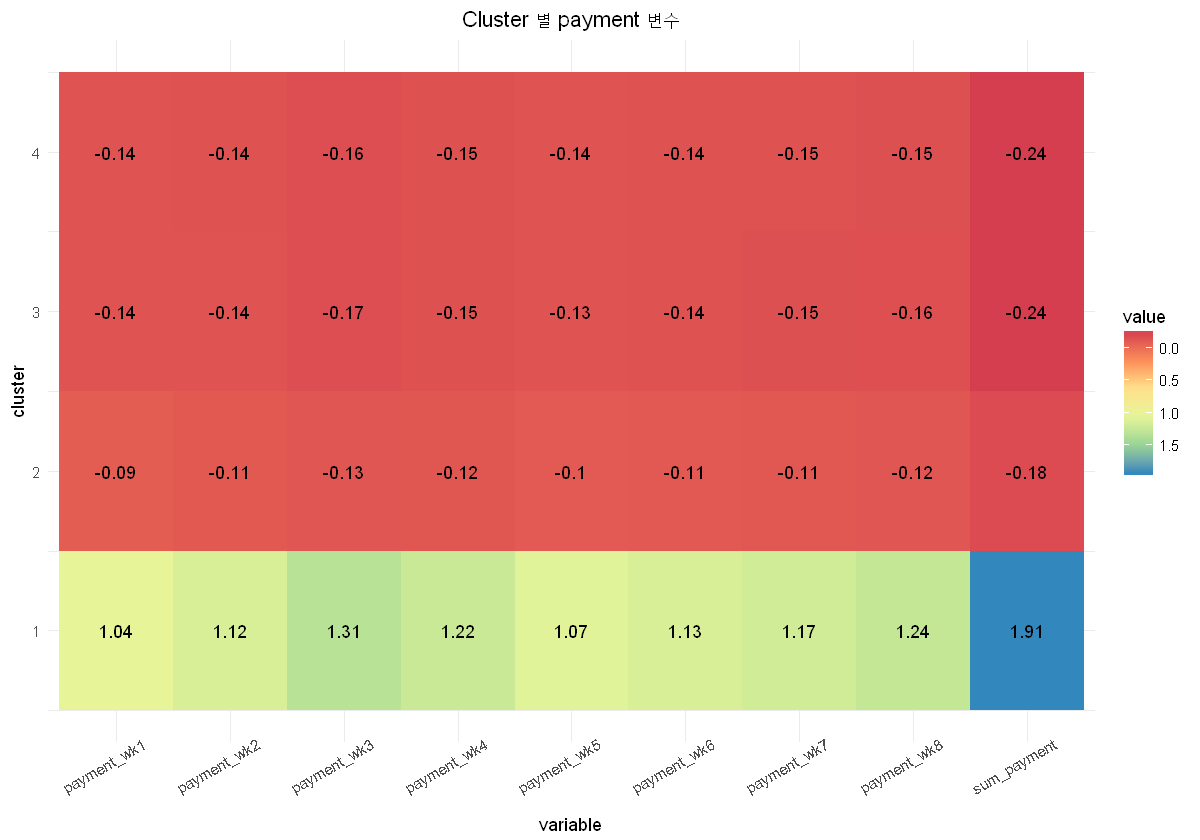

In [86]:
center_result[,c(13:21,37)] %>% 
  gather(key = "variable", value = "value", -cluster) %>%
  ggplot(aes(variable, cluster, fill = value)) + 
  geom_tile() + geom_text(aes(label = round(value, 2))) +
  scale_fill_distiller(name = "value", palette = "Spectral", tran = "reverse") +
  labs(title = "Cluster 별 payment 변수") +
  theme(axis.text.x = element_text(angle = 30, hjust = 0.7), plot.title = element_text(hjust = 0.5))

* Cluster 1 : Payment 변수들이 매우 높음

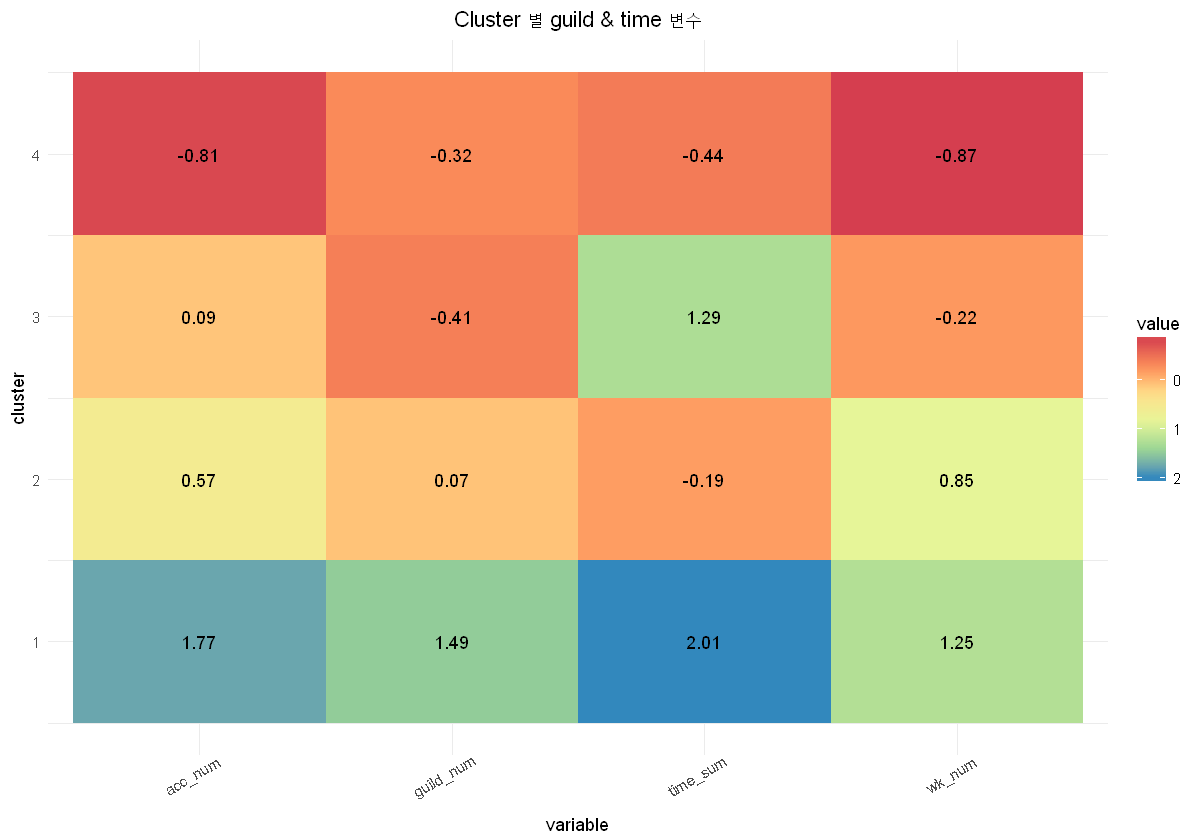

In [87]:
center_result[,c(22:25,37)] %>% 
  gather(key = "variable", value = "value", -cluster) %>%
  ggplot(aes(variable, cluster, fill = value)) + 
  geom_tile() + geom_text(aes(label = round(value, 2))) +
  scale_fill_distiller(name = "value", palette = "Spectral", tran = "reverse") +
  labs(title = "Cluster 별 guild & time 변수") +
  theme(axis.text.x = element_text(angle = 30, hjust = 0.7), plot.title = element_text(hjust = 0.5))

* Cluster 3 : time_sum이 Cluster 2와 4에 비해 상대적으로 높음
* Cluster 4 : acc_num / wk_num이 매우 낮음
* Cluster 2 : time_sum에 비해 acc_num과 wk_num이 높음

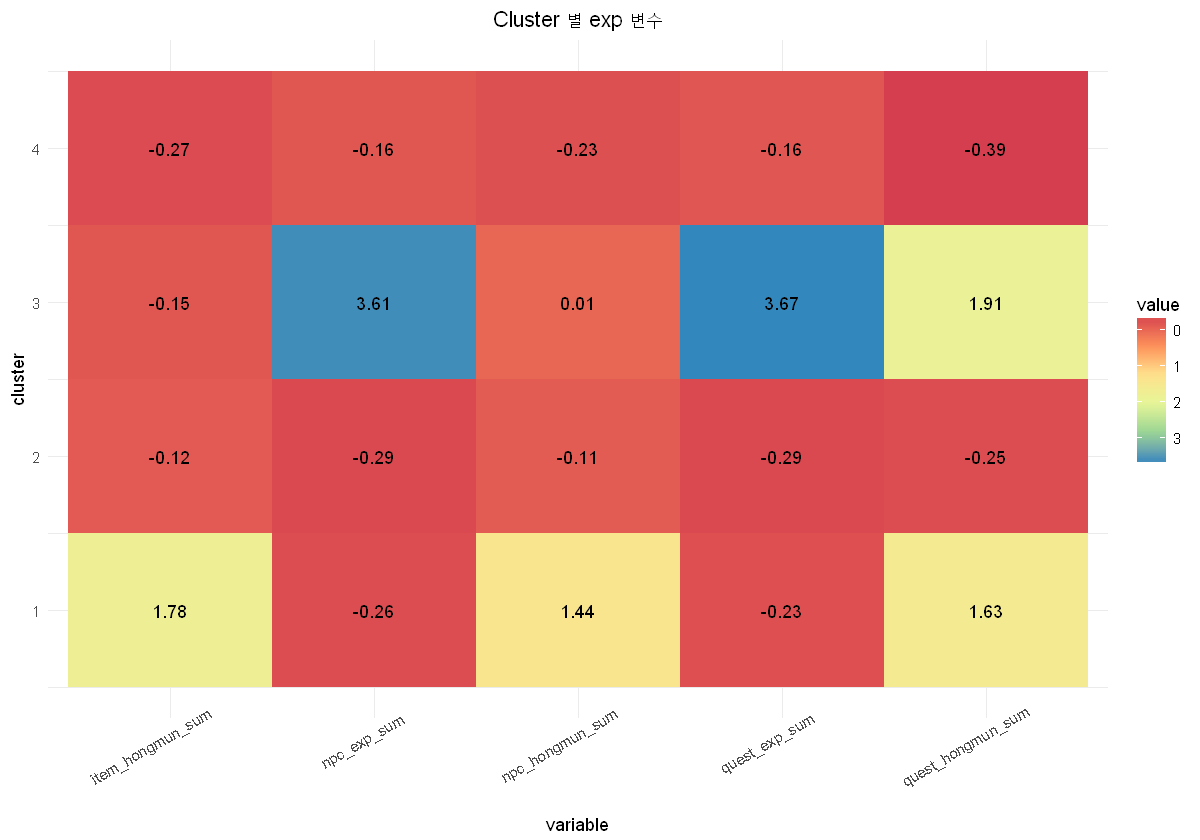

In [88]:
center_result[,c(26:30,37)] %>% 
  gather(key = "variable", value = "value", -cluster) %>%
  ggplot(aes(variable, cluster, fill = value)) + 
  geom_tile() + geom_text(aes(label = round(value, 2))) +
  scale_fill_distiller(name = "value", palette = "Spectral", tran = "reverse") +
  labs(title = "Cluster 별 exp 변수") +
  theme(axis.text.x = element_text(angle = 30, hjust = 0.7), plot.title = element_text(hjust = 0.5))

* Cluster 1 : item_hongmn_sum / npc_hongmun_sum / quest_hongmun_sum이 높음
* Cluster 3 : npc_exp_sum / quest_exp_mean이 매우 높음

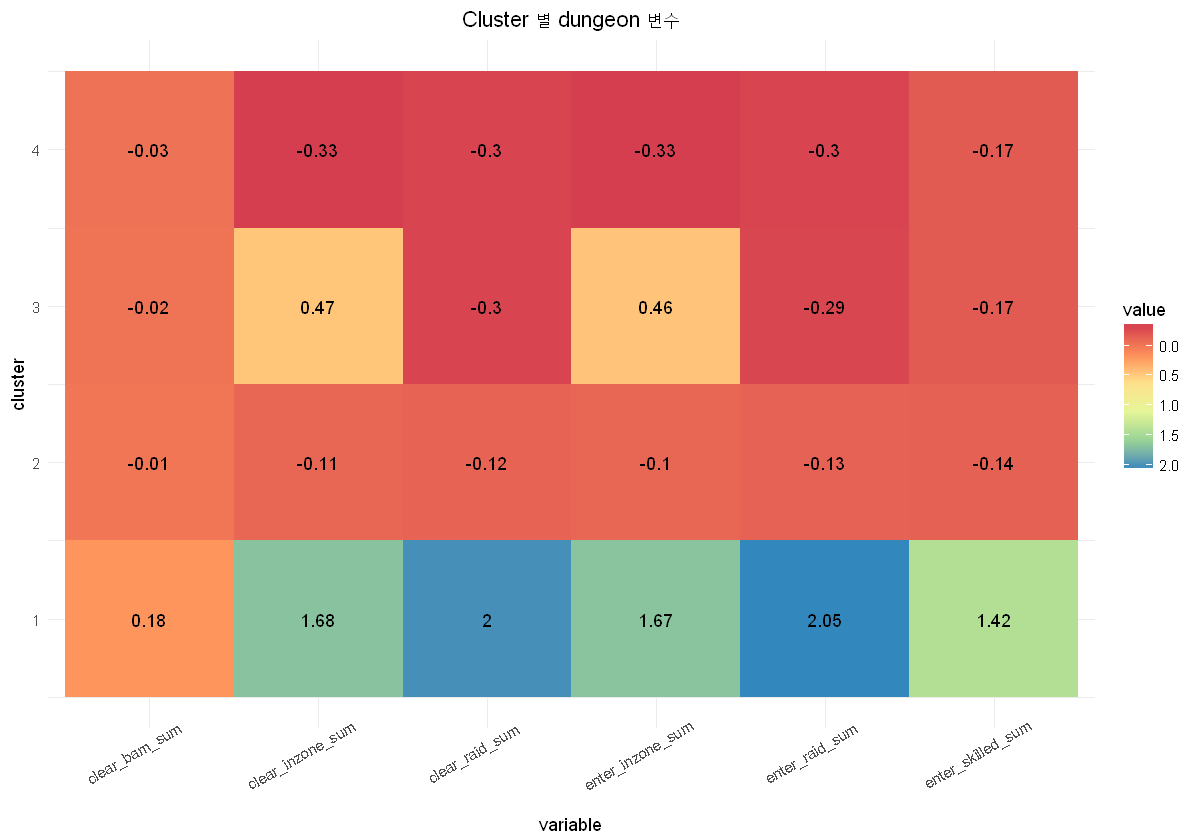

In [89]:
center_result[,c(31:37)] %>% 
  gather(key = "variable", value = "value", -cluster) %>%
  ggplot(aes(variable, cluster, fill = value)) + 
  geom_tile() + geom_text(aes(label = round(value, 2))) +
  scale_fill_distiller(name = "value", palette = "Spectral", tran = "reverse") +
  labs(title = "Cluster 별 dungeon 변수") +
  theme(axis.text.x = element_text(angle = 30, hjust = 0.7), plot.title = element_text(hjust = 0.5))

* Cluster 1 : 전반적으로 dungeon 변수가 높음
* Cluster 3 : inzone_sum 변수가 Cluster 2와 4에 비해 상대적으로 높음